<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/LSTM_Rainfall_Forecasting_Station_%7Bstation%7D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Input shape: (1431, 30, 1), Output shape: (1431, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0096 - val_loss: 6.3538e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0107 - val_loss: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0085 - val_loss: 6.2909e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0100 - val_loss: 6.5815e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070 - val_loss: 6.2824e-04
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0084 - val_loss: 6.4089e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - val_loss: 6.4044e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070 - val_loss: 6.6835e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0082 - val_loss: 6.7687e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0067 - val_loss: 6.9345e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0065 - val_loss: 6.5605e-04
Epoch 12/20
33/33 ━━━━━

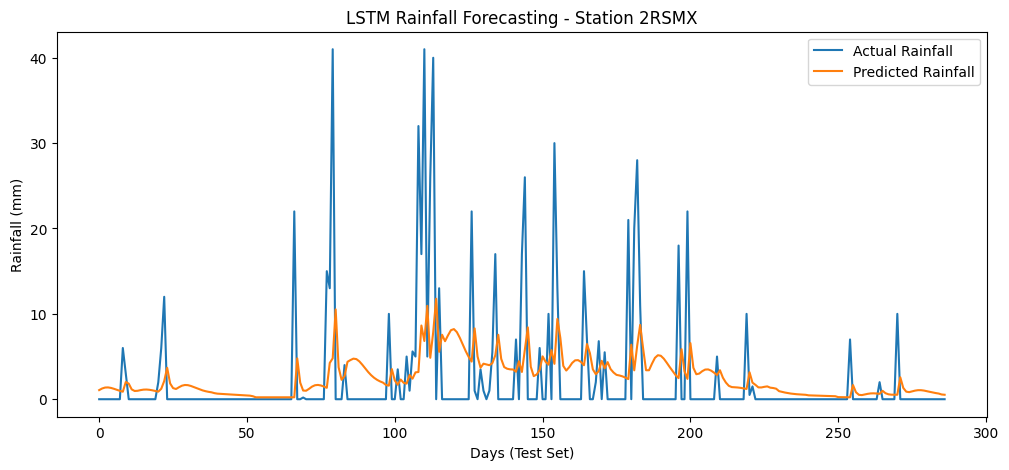

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load Real Data
# ---------------------------
# Carga el CSV
df = pd.read_csv("data/All_rain_Valle_bien.csv")

# Seleccionar la estación a trabajar (ejemplo: 2RSMX)
station = "2RSMX"
rain = df[station].values.reshape(-1, 1)

# Manejo de valores faltantes: reemplazar NaN por 0
rain = np.nan_to_num(rain, nan=0.0)

# ---------------------------
# 2. Normalize data
# ---------------------------
scaler = MinMaxScaler()
rain_scaled = scaler.fit_transform(rain)

# ---------------------------
# 3. Create Sequences
# ---------------------------
window_size = 30  # past 30 days -> predict next day

X, y = [], []
for i in range(len(rain_scaled) - window_size):
    X.append(rain_scaled[i:i+window_size])
    y.append(rain_scaled[i+window_size])

X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}, Output shape: {y.shape}")

# ---------------------------
# 4. Split Train/Test
# ---------------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------------
# 5. Build LSTM Model
# ---------------------------
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ---------------------------
# 6. Train Model
# ---------------------------
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, verbose=1)

# ---------------------------
# 7. Evaluate Model
# ---------------------------
loss = model.evaluate(X_test, y_test)
print(f"Test MSE: {loss:.4f}")

# ---------------------------
# 8. Make Predictions
# ---------------------------
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# ---------------------------
# 9. Plot Results
# ---------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test_rescaled, label="Actual Rainfall")
plt.plot(predictions_rescaled, label="Predicted Rainfall")
plt.legend()
plt.title(f"LSTM Rainfall Forecasting - Station {station}")
plt.xlabel("Days (Test Set)")
plt.ylabel("Rainfall (mm)")
plt.show()
